In [32]:
import osmnx as ox
import networkx as nx  # python's standard graph module needed by osmnx
import folium  # needed by osmnx
import pandas as pd
from collections import defaultdict
import itertools

In [33]:
place_names = ['UBC', 'Pacific Spirit Regional Park, BC', 'Vancouver, BC']
local = ox.geocode_to_gdf(place_names)

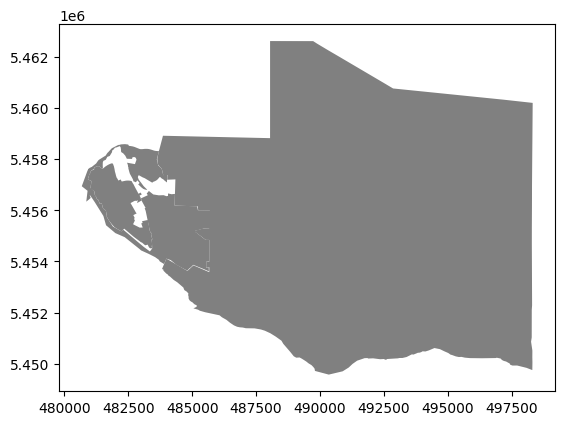

In [34]:
# show the region (project to avoid skew, but leave data in latlong for computation)
toshow = ox.project_gdf(local) #move the coordinates to something that looks nice
ax = toshow.plot(fc='gray', ec='none')

In [35]:
unified = local.unary_union.convex_hull

In [36]:
G = ox.graph_from_polygon(unified, network_type='drive', truncate_by_edge=True,
                          simplify=True)

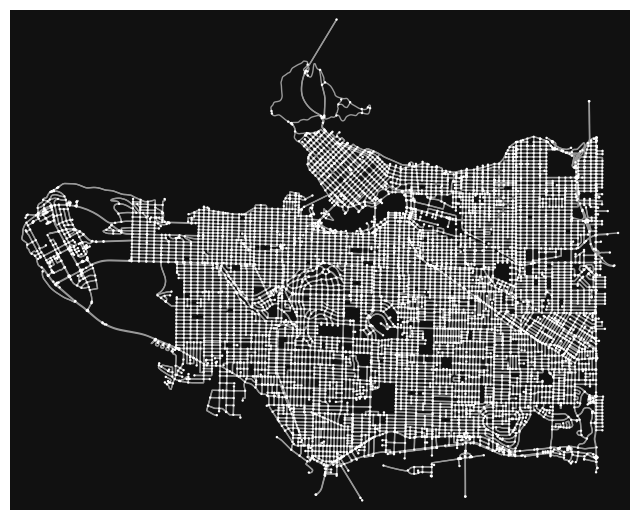

In [37]:
ax2 = ox.plot_graph(ox.project_graph(G),node_size=3)

In [38]:
errands = [
           'Nat Bailey Stadium, Vancouver, BC', 
           'PNE, Vancouver, BC',
           'Science World', 
           'Oakridge Park, Vancouver', 
           'Granville St & W King Edward Ave, Vancouver, BC',
           'Cambie St & W 16th Ave, Vancouver, BC',
           'Granville Island', 
           'Pallet Coffee Roasters, Vancouver, BC', 
           'Jericho Beach, Vancouver, BC',
           'Point Grey Secondary, Vancouver, BC'
           ]
dferrands = pd.DataFrame({'errand': errands})  # change the list into a dataframe so we can use it w osmnx

In [39]:
dferrands['latlong'] = dferrands.apply(lambda row: ox.geocode(row['errand']), axis=1)  # add lat/long to the df


In [42]:
dferrands['node'] = dferrands.apply(lambda row: ox.nearest_nodes(G, X = row['latlong'][1], Y = row['latlong'][0]), axis=1)  # add node ID to df

dferrands

,errand,latlong,node
0,"Nat Bailey Stadium, Vancouver, BC","(49.24278325, -123.10672089206204)",8008137166
1,"PNE, Vancouver, BC","(49.2823238, -123.0430151420666)",334409179
2,Science World,"(49.27345364999999, -123.10367393476372)",9172891312
3,"Oakridge Park, Vancouver","(49.2330765, -123.1161026)",338817524
4,"Granville St & W King Edward Ave, Vancouver, BC","(49.2492529, -123.1387102)",11102806917
5,"Cambie St & W 16th Ave, Vancouver, BC","(49.2569916, -123.115465)",11136507565
6,Granville Island,"(49.270713, -123.1342858)",253907342
7,"Pallet Coffee Roasters, Vancouver, BC","(49.2636034, -123.1508333)",247688383
8,"Jericho Beach, Vancouver, BC","(49.274102, -123.19687374133949)",3666548124
9,"Point Grey Secondary, Vancouver, BC","(49.23721225, -123.15288836157708)",251457181


In [43]:
dfdict = defaultdict(lambda: defaultdict())
dfdist = defaultdict(lambda: defaultdict())

for idx1, row1 in dferrands.iterrows():
    for idx2, row2 in dferrands.iterrows():
        if nx.has_path(G, row1['node'], row2['node']):
            dfdict[row1['node']][row2['node']] = nx.shortest_path(G, row1['node'], row2['node'], weight='length')
            dfdist[row1['node']][row2['node']] = nx.shortest_path_length(G, row1['node'], row2['node'], weight='length')
        else:
            print("we don't like " + str(row1['node']) + " and " + str(row2['node']))

In [44]:
def tourlength(tour):
    sum = 0
    for k, val in enumerate(tour):
        sum += dfdist[tour[k]][
            tour[(k + 1) % len(tour)]]  # need a bit of error handling, since some paths may not exist
    return sum

In [45]:
tours = list(itertools.permutations(list(dferrands['node'])))  # all possible tours, including reverses


In [46]:
# classic "find min"
besttourdist = tourlength(tours[0])
besttour = tours[0]

In [47]:
for t in tours:
    if tourlength(t) < besttourdist:
        besttourdist = tourlength(t)
        besttour = t

In [48]:
bestroute = [besttour[0]]
for index, place in enumerate(besttour):
    bestroute += (nx.shortest_path(G, besttour[index], 
                                   besttour[(index + 1) % len(besttour)], 
                                   weight='length'))[1:]


In [52]:
kwargs = {'color':'#AA1111','width':3}
m = ox.plot_route_folium(G, bestroute, popup_attribute='name',**kwargs)


# function to create a marker for each errand, and add it to the map
def buildMarker(row):
    folium.CircleMarker((row['latlong'][0], row['latlong'][1]), popup_attribute=row['errand'],
                        color='green', radius=5, fill=True).add_to(m)
    
dferrands.apply(buildMarker, axis=1)
home = dferrands.iloc[0]
folium.CircleMarker((home['latlong'][0], home['latlong'][1]), popup_attribute=home['errand'],
                    color='blue', radius=10, fill=True, fill_opacity=1.0).add_to(m)

# Show map
m


/var/folders/64/bfv2dn992m17r4ztvfrt93rh0000gn/T/ipykernel_71426/1528205740.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_route_folium(G, bestroute, popup_attribute='name',**kwargs)
